# Dummy Yolo Model

In [2]:
from ultralytics import YOLO

model = YOLO('yolov8n')

results = model.predict('/home/julianzu/Analytics/Ultilitycs/test 08 may/input_videos/drone trimmed.mp4', save = True)
print(results[0])
print('==================================')
for box in results[0].boxes:
    print(box)




ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant',

# Trainning

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="3205MH29k2z3u5Ejc3HU") # THIS API KEY IS REVOKED. PLEASE USE YOUR OWN API KEY
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(1)
dataset = version.download("yolov5")

In [ ]:
dataset.location

In [ ]:
import shutil

shutil.move('football-players-detection-1/train',
            'football-players-detection-1/football-players-detection-1/train'
            )

shutil.move('football-players-detection-1/test',
            'football-players-detection-1/football-players-detection-1/test'
            )

shutil.move('football-players-detection-1/valid',
            'football-players-detection-1/football-players-detection-1/valid'
            )

In [ ]:

!yolo task=detect mode=train model=yolov5x.pt data={dataset.location}/data.yaml epochs=100 imgsz=640

# Of Model

In [1]:
import cv2
def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    return frames

def save_video(output_video_frames, output_path):
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, 24, (output_video_frames[0].shape[1], output_video_frames[0].shape[0]))
    for frame in output_video_frames:
        out.write(frame)
    out.release()

## MAIN

### Tracker

In [2]:
from ultralytics import YOLO
import supervision as sv
import cv2
import pickle
import os
import sys


In [3]:
#bbox utils:
def get_center_of_bbox(bbox):
    x1,y1,x2,y2 = bbox
    return int((x1+x2)/2), int((y1+y2)/2)

def get_bbox_width(bbox):
    return bbox[2]-bbox[0]

In [57]:
class Tracker:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.tracker = sv.ByteTrack()

    def detect_frames(self, frames):
        batch_size = 20
        detections = []
        for i in range(0, len(frames), batch_size):
            detections_batch = self.model.predict(frames[i:i+batch_size],conf=0.1)
            detections += detections_batch
        return detections

    def get_object_tracks(self, frames, read_from_stub= False, stub_path = None):

        if read_from_stub and stub_path is not None and os.path.exists(stub_path):
            with open(stub_path, 'rb') as f:
                tracks = pickle.load(f)
            return tracks

        detections = self.detect_frames(frames)

        tracks = {"players":[]}

        for frame_num, detection in enumerate(detections):
            cls_names = detection.names
            cls_names_inv = {v:k for k,v in cls_names.items()}
            print(cls_names)

            #convert to supervision detecton format
            detection_supervision = sv.Detections.from_ultralytics(detection)

            #track Objects
            detection_with_tracks = self.tracker.update_with_detections(detection_supervision)

            tracks['players'].append({})

            for frame_detection in detection_with_tracks:
                bbox = frame_detection[0].tolist()
                cls_id = frame_detection[3]
                track_id = frame_detection[4]

                if cls_id == cls_names_inv['player']:
                    tracks["players"][frame_num][track_id] = {"bbox":bbox}

        if stub_path is not None:
            with open(stub_path, 'wb') as f:
                pickle.dump(tracks,f)

        return tracks


    def draw_ellipse(self, frame, bbox, color, track_id):
        y2 = int(bbox[3])

        x_center, _ = get_center_of_bbox(bbox)
        width = get_bbox_width(bbox)

        cv2.ellipse(
            frame,
            center=(x_center,y2),
            axes=(int(width), int(0.35*width)),
            angle=0.0,
            startAngle=-45,
            endAngle=235,
            color = color,
            thickness=2,
            lineType=cv2.LINE_4
        )

        rectangle_width = 40
        rectangle_height=20
        x1_rect = x_center - rectangle_width//2
        x2_rect = x_center + rectangle_width//2
        y1_rect = (y2- rectangle_height//2) +15
        y2_rect = (y2+ rectangle_height//2) +15

        if track_id is not None:
            cv2.rectangle(frame,
                          (int(x1_rect),int(y1_rect) ),
                          (int(x2_rect),int(y2_rect)),
                          color,
                          cv2.FILLED)
            
            x1_text = x1_rect+12
            if track_id > 99:
                x1_text -=10
            
            cv2.putText(
                frame,
                f"{track_id}",
                (int(x1_text),int(y1_rect+15)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0,0,0),
                2
            )
        return frame




    def draw_annotations(self, video_frames, tracks):
        output_video_frames = []
        for frame_num, frame in enumerate(video_frames):
            frame = frame.copy()

            player_dict = tracks["players"][frame_num]

            # Draw Players
            for track_id, player in player_dict.items():
                color = player.get("team_color",(0,0,255))
                frame = self.draw_ellipse(frame, player["bbox"],color, track_id)



            output_video_frames.append(frame)

        return output_video_frames


In [66]:
print(player_dict)

NameError: name 'player_dict' is not defined

# MAIN

In [65]:
# READ video:
video_frames = read_video('/home/julianzu/Analytics/Ultilitycs/test 08 may/input_videos/drone trimmed.mp4')




#initialize Tracker
tracker = Tracker('/home/julianzu/Analytics/Ultilitycs/test 08 may/models/bestfutbol.pt')


#Assign player teams
team_assigner = teamAssigner()
team_assigner.assign_team_color(video_frames[0], tracks['players'][0])


for frame_num, player_track in enumerate(tracks['players']):
    for player_id, track in player_track.items():
        team = team_assigner.get_player_team(video_frames[frame_num],
                                             track['bbox'],
                                             player_id)
        
        tracks['players'][frame_num][player_id]['team'] = team
        tracks['players'][frame_num][player_id]['team_color'] = team_assigner.team_colors[team]




# Save Cropped image of a player
for track_id, player in tracks['players'][0].items():
    bbox = player['bbox']
    frame = video_frames[0]

    #crop bbox from frame
    cropped_image = frame[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]

    #save the cropped image
    cv2.imwrite(f'output_videos/crepped_imgage.jpg', cropped_image)

    break


tracks = tracker.get_object_tracks(video_frames, read_from_stub = True, stub_path = '/home/julianzu/Analytics/Ultilitycs/test 08 may/stubs/track_stubs.pkl' )

#draw output
## draw object tracks
output_video_frames = tracker.draw_annotations(video_frames, tracks)

#save Video:
save_video(output_video_frames, '/home/julianzu/Analytics/Ultilitycs/test 08 may/output_videos/drone trimmed.avi')


# Developement and Analysis

## Color assignamet

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans 


In [16]:
image_path = "/home/julianzu/Analytics/Ultilitycs/test 08 may/output_videos/crepped_imgage.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


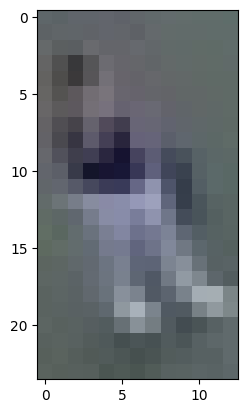

In [17]:
plt.imshow(image)
plt.show()


### Take the tophalf of the image

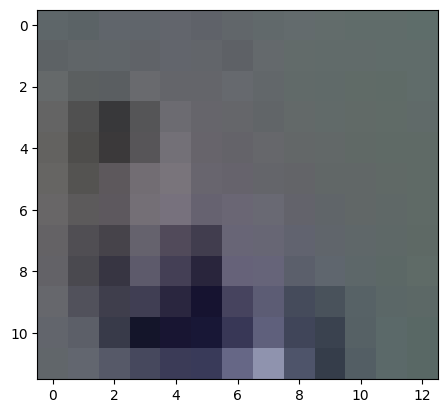

In [20]:
top_half_image = image[0: int(image.shape[0]/2), :]
plt.imshow(top_half_image)
plt.show()

### Cluster the image into two clusters

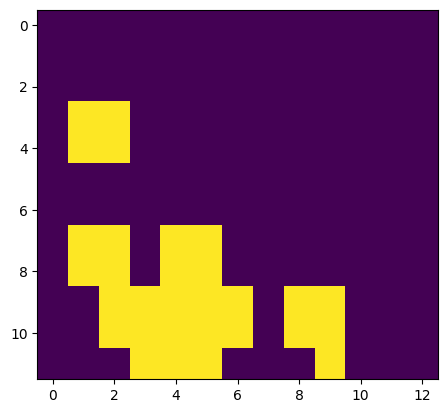

In [35]:
# reshape the image into a 2d array
image_2d = top_half_image.reshape(-1,3)

#perform k - means clustering with two clusters
kmeans = KMeans(n_clusters=2, random_state= 0)
kmeans.fit(image_2d)

# get the cluster labels:
labels = kmeans.labels_

#reshape the labels into the original image shape
clustered_image = labels.reshape(top_half_image.shape[0], top_half_image.shape[1])

#display the clustered image
plt.imshow(clustered_image)
plt.show()




In [36]:
corner_clusters = [clustered_image[0, 0], clustered_image[0,-1], clustered_image[-1, 0], clustered_image[-1, -1]]
non_player_cluster = max(set(corner_clusters), key = corner_clusters.count)
print(non_player_cluster)


0


In [37]:
player_cluster =1 - non_player_cluster
print(player_cluster)

1


In [38]:
kmeans.cluster_centers_[player_cluster]

array([     58.367,      58.133,      74.933])

## Team assigner


In [64]:
class TeamAssigner:
    def __init__(self):
        self.team_colors = {}
        self.player_team_dict = {}
    
    def get_clustering_model(self,image):
        # Reshape the image to 2D array
        image_2d = image.reshape(-1,3)

        # Preform K-means with 2 clusters
        kmeans = KMeans(n_clusters=2, init="k-means++",n_init=1)
        kmeans.fit(image_2d)

        return kmeans

    def get_player_color(self,frame,bbox):
        image = frame[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2])]

        top_half_image = image[0:int(image.shape[0]/2),:]

        # Get Clustering model
        kmeans = self.get_clustering_model(top_half_image)

        # Get the cluster labels forr each pixel
        labels = kmeans.labels_

        # Reshape the labels to the image shape
        clustered_image = labels.reshape(top_half_image.shape[0],top_half_image.shape[1])

        # Get the player cluster
        corner_clusters = [clustered_image[0,0],clustered_image[0,-1],clustered_image[-1,0],clustered_image[-1,-1]]
        non_player_cluster = max(set(corner_clusters),key=corner_clusters.count)
        player_cluster = 1 - non_player_cluster

        player_color = kmeans.cluster_centers_[player_cluster]

        return player_color


    def assign_team_color(self,frame, player_detections):
        
        player_colors = []
        for _, player_detection in player_detections.items():
            bbox = player_detection["bbox"]
            player_color =  self.get_player_color(frame,bbox)
            player_colors.append(player_color)
        
        kmeans = KMeans(n_clusters=2, init="k-means++",n_init=10)
        kmeans.fit(player_colors)

        self.kmeans = kmeans

        self.team_colors[1] = kmeans.cluster_centers_[0]
        self.team_colors[2] = kmeans.cluster_centers_[1]


    def get_player_team(self,frame,player_bbox,player_id):
        if player_id in self.player_team_dict:
            return self.player_team_dict[player_id]

        player_color = self.get_player_color(frame,player_bbox)

        team_id = self.kmeans.predict(player_color.reshape(1,-1))[0]
        team_id+=1

        if player_id ==91:
            team_id=1

        self.player_team_dict[player_id] = team_id

        return team_id

In [60]:
class teamAssigner:
    def __init__(self):
        self.team_colors = {}
        self.player_team_dict = {}


    def get_clustering_model(self, image):
        # reshape the image to 2d array
        image_2d = image.reshape(-1,3)

        #preform k means with two clusters
        kmeans = KMeans(n_clusters=2, init="k-means++", n_init=1)
        kmeans.fit(image_2d)

        return kmeans


    def get_player_color(self, frame, bbox):
        image = frame[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2])]
        
        top_half_image = image[0:int(image.shape[0]/2),:]

        #get clustering model
        kmeans = self.get_clustering_model(top_half_image)

        #get the cluster labels for each pixel
        labels = kmeans.labels_

        #reshape the labels to the image shape

        clustered_image = labels.reshape(top_half_image.shape[0],top_half_image.shape[1])

        #get the player cluster
        corner_clusters = [clustered_image[0,0], clustered_image[0,-1], clustered_image[-1,0], clustered_image[-1,-1]]
        non_player_cluster = max(set(corner_clusters), key= corner_clusters.count)
        player_cluster = 1 - non_player_cluster

        player_color = kmeans.cluster_centers_[player_cluster]

        return player_color


    def assign_team_color(self, frame, player_detections):
        player_colors = []
        for _, player_detection in player_detections.items():
            bbox = player_detection['bbox']
            player_color = self.get_player_color(frame, bbox)
            player_colors.append(player_color)

        kmeans = KMeans(n_clusters = 2, init = "k-means++", n_init =10)
        kmeans.fit(player_colors)

        self.kmeans = kmeans


        self.team_colors[1] = kmeans.cluster_centers_[0]
        self.team_colors[2] = kmeans.cluster_centers_[1]


    def get_player_team(self, frame, player_bbox, player_id):
        if player_id in self.player_team_dict:
            return self.player_team_dict[player_id]
        
        player_color = self.get_player_color(frame, player_bbox)

        team_id = self.kmeans.predict(player_color.reshape(1,-1))[0]
        team_id += 1

        self.player_team_dict[player_id] = team_id

        return team_id